In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


#  データの取得

In [2]:
# trainとtestデータをdfs['train'],dfs['test']として取得
dfs = {}
for name in ['train','test']:
    df = pd.read_csv('/kaggle/input/bike-sharing-demand/%s.csv' % name)
    df['_data'] = name
    dfs[name] = df

In [3]:
# trainとtestデータをdfにまとめる
df = dfs['train'].append(dfs['test'])

# lowercase column names
df.columns = map(str.lower, df.columns)

In [4]:
# casual,registered,countに対し、それぞれ対数を取った変数 casual_log,registered_log,count_log を定義する
# 真数条件満たすため、対数変換するときにcasual,registered,countに1を足す
for col in ['casual', 'registered', 'count']:
    df['%s_log' % col] = np.log(df[col] + 1)

In [5]:
# datetimeからdate,day,month,year,hour,dow(day of week;曜日),woy(week of year;年初めから数えた週数)を取得
dt = pd.DatetimeIndex(df['datetime'])
df.set_index(dt, inplace=False)

df['date'] = dt.date
df['day'] = dt.day
df['month'] = dt.month
df['year'] = dt.year
df['hour'] = dt.hour
df['dow'] = dt.dayofweek
df['woy'] = dt.weekofyear

df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,casual_log,registered_log,count_log,date,day,month,year,hour,dow,woy
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,...,1.386294,2.639057,2.833213,2011-01-01,1,1,2011,0,5,52
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,...,2.197225,3.496508,3.713572,2011-01-01,1,1,2011,1,5,52
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,...,1.791759,3.332205,3.496508,2011-01-01,1,1,2011,2,5,52
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,...,1.386294,2.397895,2.639057,2011-01-01,1,1,2011,3,5,52
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,...,0.000000,0.693147,0.693147,2011-01-01,1,1,2011,4,5,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,...,NaN,NaN,NaN,2012-12-31,31,12,2012,19,0,1
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,...,NaN,NaN,NaN,2012-12-31,31,12,2012,20,0,1
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,...,NaN,NaN,NaN,2012-12-31,31,12,2012,21,0,1
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,...,NaN,NaN,NaN,2012-12-31,31,12,2012,22,0,1


# データクレンジング

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,casual,registered,...,registered_log,count_log,date,day,month,year,hour,dow,woy,windspeed
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,3.0,13.0,...,2.639057,2.833213,2011-01-01,1,1,2011,0,5,52,7.201964
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,8.0,32.0,...,3.496508,3.713572,2011-01-01,1,1,2011,1,5,52,6.980674
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,5.0,27.0,...,3.332205,3.496508,2011-01-01,1,1,2011,2,5,52,6.980674
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,3.0,10.0,...,2.397895,2.639057,2011-01-01,1,1,2011,3,5,52,6.958111
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1.0,...,0.693147,0.693147,2011-01-01,1,1,2011,4,5,52,6.958111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,NaN,NaN,...,NaN,NaN,2012-12-31,31,12,2012,19,0,1,11.001400
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,NaN,NaN,...,NaN,NaN,2012-12-31,31,12,2012,20,0,1,11.001400
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,NaN,NaN,...,NaN,NaN,2012-12-31,31,12,2012,21,0,1,11.001400
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,NaN,NaN,...,NaN,NaN,2012-12-31,31,12,2012,22,0,1,8.998100


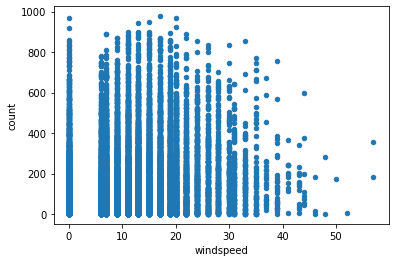

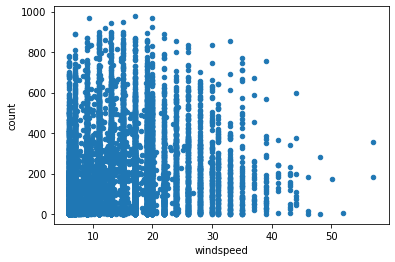

In [6]:
#windspeed（風速）の補正

df.plot.scatter(x='windspeed',y='count')

#風速が0以外のデータでランダムフォレストモデルで風速を予測
dataWind0 = df[df["windspeed"]==0]
dataWindNot0 = df[df["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])
 
#風速が0のデータを、予測したモデルで風速を補正する
wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
#data = dataWindNot0.append(dataWind0)
#data.reset_index(inplace=True)
#data.drop('index',inplace=True,axis=1)

#予測したデータをdfに反映させる
df = pd.merge(df, dataWind0[["datetime", "windspeed"]], how="left", on="datetime")
df["windspeed_y"] = df["windspeed_y"].fillna(0)

df["windspeed"] = df["windspeed_x"] + df["windspeed_y"]
df = df.drop(columns=["windspeed_x", "windspeed_y"])

df.plot.scatter(x='windspeed',y='count')
df

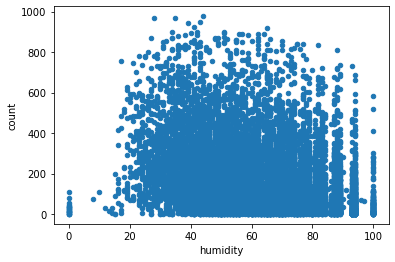

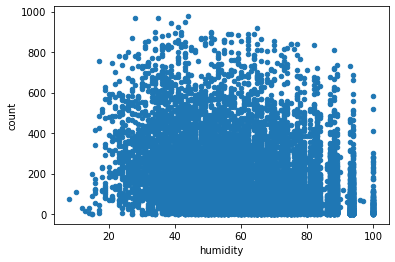

In [7]:
#humidity(湿度)が0のデータを削除

df.plot.scatter(x='humidity',y='count')

df.drop(df[df['humidity'] <= 2].index, inplace=True)

df.plot.scatter(x='humidity',y='count')

# 特徴量エンジニアリング

In [8]:
#Tax day(確定申告日)をworkingdayに、Thanksgiving Friday(謝肉祭)とStorms,Tornado Sandy(大型ハリケーン)、クリスマス、大晦日をholidayにする

# def get_day(day_start):
#     day_end = day_start + pd.offsets.DateOffset(hours=23)
#     return pd.date_range(day_start, day_end, freq="h")

df['datetime'] = pd.to_datetime(df['datetime'])

dates = [
    (pd.Timestamp(2011, 4, 15), 1, 0),  # Tax day
    (pd.Timestamp(2012, 4, 16), 1, 0),  # Tax day
    (pd.Timestamp(2011, 11, 25), 0, 1),  # Thanksgiving Friday
    (pd.Timestamp(2012, 11, 23), 0, 1),  # Thanksgiving Friday
    (pd.Timestamp(2011, 12, 24), 0, 1),  # Christmas
    (pd.Timestamp(2012, 12, 24), 0, 1),  # Christmas
    (pd.Timestamp(2011, 12, 26), 0, 1),  # Christmas
    (pd.Timestamp(2012, 12, 26), 0, 1),  # Christmas
    (pd.Timestamp(2011, 12, 31), 0, 1),  #New Year’s Eve
    (pd.Timestamp(2012, 12, 31), 0, 1),  #New Year’s Eve
    (pd.Timestamp(2012, 5, 21), 0, 1),  # Storms
    (pd.Timestamp(2012, 6, 1), 0, 1),  # Tornado
    (pd.Timestamp(2012, 10, 30), 0, 1),  # Sandy
]

for date, workingday_value, holiday_value in dates:
    df.loc[df['datetime'].dt.date == date.date(), 'workingday'] = workingday_value
    df.loc[df['datetime'].dt.date == date.date(), 'holiday'] = holiday_value
# for date, workingday, holiday in dates:
#     all_df.loc[get_day(date)[0], "workingday"] = workingday
#     all_df.loc[get_day(date)[0], "holiday"] = holiday



In [9]:
#working,holidayで使用数のピークが異なる。特徴量としてpeakを導入

df['peak'] = df[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18 or 12 <= x['hour'] <= 13)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
#温度、風速条件を用いてideal(快適フラグ)、湿度、仕事日をもちてsticky（不適フラグ）を導入

df['ideal'] = df[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
df['sticky'] = df[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)
#df['peak'] = df[['holiday', 'workingday', 'hour']].apply(lambda x: (0, 1)[x['workingday'] == 1 and (x['hour'] == 8 or 12 <= x['hour'] <= 13 or 17 <= x['hour'] <= 18)], axis = 1).apply(lambda x: (0, 1)[x['holiday'] == 1 and 10 <= x['hour'] <= 19], axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  after removing the cwd from sys.path.


# モデリング

In [11]:
#関数の定義

def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)


def get_data():
    data = df[df['_data'] == 'train'].copy()
    return data


def custom_train_test_split(data, cutoff_day=15):
    train = data[data['day'] <= cutoff_day]
    test = data[data['day'] > cutoff_day]

    return train, test


def prep_data(data, input_cols):
    X = data[input_cols]
    y_r = data['registered_log']
    y_c = data['casual_log']

    return X, y_r, y_c


def predict_on_validation_set(model, input_cols):
    data = get_data()

    train, test = custom_train_test_split(data)

    X_train, y_train_r, y_train_c = prep_data(train, input_cols)
    X_test, y_test_r, y_test_c = prep_data(test, input_cols)

    model_r = model.fit(X_train, y_train_r)
    y_pred_r = np.exp(model_r.predict(X_test)) - 1

    model_c = model.fit(X_train, y_train_c)
    y_pred_c = np.exp(model_c.predict(X_test)) - 1

    y_pred_comb = np.round(y_pred_r + y_pred_c)
    y_pred_comb[y_pred_comb < 0] = 0

    y_test_comb = np.exp(y_test_r) + np.exp(y_test_c) - 2

    score = get_rmsle(y_pred_comb, y_test_comb)
    return (y_pred_comb, y_test_comb, score)

df_test = df[df['_data'] == 'test'].copy()

# predict on test set & transform output back from log scale
def predict_on_test_set(model, x_cols):
    # prepare training set
    df_train = df[df['_data'] == 'train'].copy()
    X_train = df_train[x_cols]
    y_train_cas = df_train['casual_log']
    y_train_reg = df_train['registered_log']

    # prepare test set
    X_test = df_test[x_cols]

    casual_model = model.fit(X_train, y_train_cas)
    y_pred_cas = casual_model.predict(X_test)
    y_pred_cas = np.exp(y_pred_cas) - 1
    registered_model = model.fit(X_train, y_train_reg)
    y_pred_reg = registered_model.predict(X_test)
    y_pred_reg = np.exp(y_pred_reg) - 1
    # add casual & registered predictions together
    return y_pred_cas + y_pred_reg

In [12]:
# random forest model
params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}
rf_model = RandomForestRegressor(**params)
rf_cols = [
    'weather', 'temp', 'windspeed',
    'workingday', 'season', 'holiday', 'sticky',
    'hour', 'dow', 'woy', 'peak',
]
rf_p, rf_t, rf_score = predict_on_validation_set(rf_model, rf_cols)
print(rf_score)

0.4338893999133992


In [13]:
# GBM model
params = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.1, 'subsample': 0.7, 'loss': 'ls'}
gbm_model = GradientBoostingRegressor(**params)
gbm_cols = [
    'weather', 'temp', 'humidity', 'windspeed',
    'holiday', 'workingday', 'season',
    'hour', 'dow', 'year', 'ideal'
    ]


(gbm_p, gbm_t, gbm_score) = predict_on_validation_set(gbm_model, gbm_cols)
print(gbm_score)

# the blend gives a better score on the leaderboard, even though it does not on the validation set
y_p = np.round(.2*rf_p + .8*gbm_p)
print(get_rmsle(y_p, rf_t))

0.30964551111605854
0.3133878257533444


In [14]:
# predctions on test dataset
rf_pred = predict_on_test_set(rf_model, rf_cols)
gbm_pred = predict_on_test_set(gbm_model, gbm_cols)


In [15]:
# taking weighted average of output from two models
y_pred = np.round(.20*rf_pred + .80*gbm_pred)


In [16]:
# output predictions for submission
df_test['count'] = y_pred
final_df = df_test[['datetime', 'count']].copy()
final_df.to_csv('output5.csv', index=False)